# TOPIC:
# <font color='green'>Use Images to Classify AGN vs non-AGN
 by Sicong Huang

# THE QUESTION:
# <font color='green'>How to prepare the data ?

# GOAL of the project:
## <font color='green'> Use images to classify AGN. Compare results with AGN_Classifer. Maybe combine those 2 to improve the final results of AGN classification.

# Analytic Approach:
# <font color='green'> Shallow CNN or ResNet

# IMPORT LIBRARIES

In [319]:
# System
import os
from io import BytesIO
from tqdm import tqdm
import h5py

# Web Scraping
import requests
from astroquery.simbad import Simbad
from urllib.parse import quote
from urllib import request

# Data Analysis
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style

# Data Visualization
import IPython.display as Disp
from PIL import Image
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
from astropy.visualization import (MinMaxInterval, ZScaleInterval, SqrtStretch, AsinhStretch, BaseStretch,
                                   ImageNormalize)

%matplotlib inline

# Functions

In [140]:
def combine_columns(df, column_names):
    '''
    This function merges the columns 
    with first come first serve order
    and returns a new df series
    '''
    col = df[column_names[0]]
    for name in column_names[1:]:
        col = col.combine_first(df[name])
    return col

# Data Requirements:
## <font color='green'>Image of each labeled source in AGNDB

# Data Collection:
## <font color='green'> Data can be obtained from http://alasky.u-strasbg.fr/hips-image-services/hips2fits

In [26]:
# Image directory
Image_path = '/data/blackbase/Images/'

# master tables
morph_csv = '/data/blackbase/final/master-merged-Morphology-store.csv'
photo_csv = '/data/blackbase/final/master-merged-Photometry-store.csv'
redshift_csv = '/data/blackbase/final/master-merged-Redshift-store.csv'

## <font color='green'> Read coordinates for labeled data AGNDB

In [4]:
df_morph = pd.read_csv(morph_csv)

/home/sicong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,4,5,6,13,14,15,16,17,18,20,26,27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df_morph.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'OTYPE_S_simbad',
       'SP_TYPE_simbad', 'MORPH_TYPE_simbad',
       'SUBCLASS_zcat.deep2.dr4_agn.fits', 'spec.type_3FGL2.fits',
       'EP_EXTENT_4XMM_DR10cat_v1.0.fits',
       'EP_EXTENT_ERR_4XMM_DR10cat_v1.0.fits', 'RA', 'DEC', 'nan_column',
       'spec_class', 'vi_class', 'gen_class', 'SED_class', 'optical_class',
       'xray_class', 'Mtype', 'SDSS_image_class', 'f_bal', 'f_class', 'f_star',
       'q_class', 'f_beam', 'source_class', 'He2_N2', 'N2_O3', 'O1_O3',
       'O3_O1', 'S2_O3', 'p_galaxy', 'p_star', 'p_qso_z'],
      dtype='object')

<font color='green'>
The priority of values to put into <b>best_class</b> column is as following:<br>
- "spec_class" > "SDSS_image_class" > "SED_class" > "vi_class" > "optical_class" > "gen_class" > "Mtype"

In [6]:
# replace 'unknown' with Nan
df_morph = df_morph.replace('unknown',np.NaN)

# create a best class column
morph_cols = ["spec_class", "SDSS_image_class", "SED_class", "vi_class", "optical_class", "gen_class", "Mtype"]
df_morph["best_class"] = combine_columns(df_morph, morph_cols)

# select labeled data with columns: ra, dec, classification
df_coord = df_morph[df_morph["best_class"].notnull()]
df_coord = df_coord[["RA", "DEC", "best_class"]]
# add an index column to keep track of the source name
df_coord['index'] = df_coord.index

In [7]:
df_coord['best_class'].value_counts()

generic_agn    467977
star           185240
galaxy          72553
blazar          27911
type1           21439
type2           10208
Name: best_class, dtype: int64

In [8]:
# replace classes with AGN and non-AGN
df_coord.rename(columns = {'best_class':'AGN'}, inplace = True)
df_coord['AGN'].replace({'generic_agn':True,
                   'blazar':True,
                   'star':False,
                   'galaxy':False,
                   'type1':True,
                   'type2':True
                    }, inplace=True)

In [9]:
df_coord['AGN'].value_counts()

True     527535
False    257793
Name: AGN, dtype: int64

In [10]:
# Downsampling AGN
# Separate majority and minority classes
df_majority = df_coord[df_coord['AGN']==1]
df_minority = df_coord[df_coord['AGN']==0]
 
# Downsample majority class
df_majority_downsampled = df_majority.sample(257793, # to match minority class
                                 replace=False,    # sample without replacement
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_coord = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_coord['AGN'].value_counts()

False    257793
True     257793
Name: AGN, dtype: int64

In [11]:
df_coord.head()

RA        DEC   AGN   index
389066   12.388525   1.202511  True  389066
315219  252.039145 -72.381006  True  315219
168741  347.080611 -38.309877  True  168741
343873  248.448168  47.210515  True  343873
372952  194.759996  -1.702588  True  372952

In [12]:
df_coord.dtypes

RA       float64
DEC      float64
AGN         bool
index      int64
dtype: object

In [16]:
# save df to file
df_coord.to_csv('coords.csv', header=['RA','DEC','AGN', 'index'], index=False)

In [3]:
df_coord = pd.read_csv('coords.csv')
df_coord.head()

RA        DEC   AGN   index
0   12.388525   1.202511  True  389066
1  252.039145 -72.381006  True  315219
2  347.080611 -38.309877  True  168741
3  248.448168  47.210515  True  343873
4  194.759996  -1.702588  True  372952

## <font color='green'>Train/dev set split
Train/dev ratio = 0.8/0.2 <br>
Set Train size = 4800 & Dev size = 1200

In [96]:
# Full size df_coord takes too long to fetch image data from website
df_train, df_dev = np.split(df_coord.sample(n=6000, random_state=123), [int(.8*6000)])

In [97]:
# reset index
df_train = df_train.reset_index()
df_dev = df_dev.reset_index()

In [49]:
df_train.to_csv('train.csv', header=['RA','DEC','AGN', 'index'], index=False)
df_dev.to_csv('dev.csv', header=['RA','DEC','AGN', 'index'], index=False)

## <font color='green'>Setup image size, list of objects, list of HiPS

In [171]:
# The file size of a 150x150 jpg file is ~ 8kb, with 1 mil images ~ 8gb
width = 150
height = 150
fov = 0.01 # in decimal degrees

# hips observations, use DSS2/red for now
# SEE https://aladin.u-strasbg.fr/hips/list
#hips_list = ['DSS2/red', 'CDS/P/AKARI/FIS/N160', 'PanSTARRS/DR1/z', '2MASS/J', 'AllWISE/W3']
hips = 'DSS2/color'

# nb_obj = len(objects)
# nb_hips = len(hips_list)

### <font color='green'>Test with galaxy image for optimal fov size

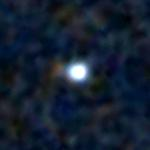

In [173]:
ra = 53.11258
dec = -27.68483
url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?hips={quote(hips)}&width={width}&height={height}&fov={fov}&projection=TAN&coordsys=icrs&ra={ra}&dec={dec}&format={"jpg"}'
Disp.Image((requests.get(url).content))

In [282]:
width = 150
height = 150
fov = 0.01

fovs = [0.01,0.01,0.01,0.01,0.01]
#objects = [(53.11258,-27.68483)]
objects = [(150.33665,55.89791)]

hips_list = ['DSS2/red', 'PanSTARRS/DR1/z',  'CDS/P/HST/H', 'CDS/P/GALEXGR6/AIS/NUV', 'CDS/P/2MASS/H']
hips_names = ['DSS2 Red (F+R)', 'PanSTARRS DR1 z',  'HST H ', 'GALEX GR6 AIS - NEAR UV', '2MASS H (1.66um)']

nb_obj = len(objects)
nb_hips = len(hips_list)

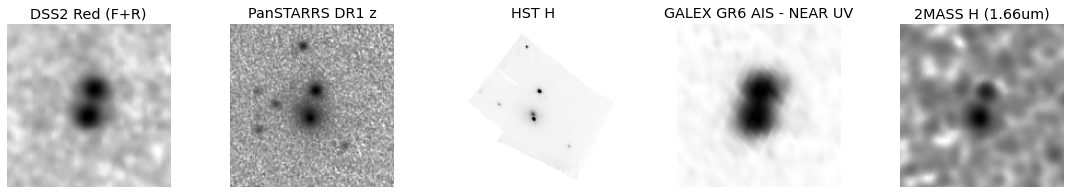

In [324]:
fig, axs = plt.subplots(nb_obj, nb_hips, figsize=(4 * nb_hips, 3* nb_obj), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()


i = 0
for obj in objects:
    for hips,name,fov in zip(hips_list,hips_names,fovs):
        axs[i].set_axis_off()

        axs[i].set_title('{}'.format(name))
        ra = obj[0]
        dec = obj[1]
        url = 'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?hips={}&width={}&height={}&fov={}&projection=TAN&coordsys=icrs&ra={}&dec={}'.format(quote(hips), width, height, fov, ra, dec)
    
        hdu = fits.open(url)
        
        im = hdu[0].data
        norm = ImageNormalize(im, interval=ZScaleInterval(contrast=0.005),
                      stretch=AsinhStretch())
        axs[i].imshow(im, cmap='gist_yarg', norm=norm, origin='lower')
        #axs[i].imshow(im, cmap='binary')
        hdu.close()
        i += 1
plt.savefig('hips2fits.pdf')

### FOV will be set to 0.1 deg

## <font color='green'> Query hips2fits service, save result as numpy array. 
    Notice that the images are in grey scale so only 1 channel is needed.

<font color='red'> Delete old h5 file if overwrite

In [52]:
# os.remove(Image_path+'train.h5')
# os.remove(Image_path+'dev.h5')

In [53]:
dic = {'train': df_train, 'dev': df_dev}
for name, df in dic.items():
    # get ra and dec list
    idx = df['index'].to_numpy()
    ras = df['RA'].to_numpy()
    decs = df['DEC'].to_numpy()
    agns = df['AGN'].to_numpy()

    # initialize the image numpy array with shape: (sample_size, width, height, channel)
    url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?hips={quote(hips)}&width={width}&height={height}&fov={fov}&projection=TAN&coordsys=icrs&ra={ras[0]}&dec={decs[0]}&format={"jpg"}'
    res = request.urlopen(url).read()
    img = Image.open(BytesIO(res))
    data = np.asarray(img)
    data = data[:,:,0]
    data = data.reshape(1,data.shape[0], data.shape[1], 1)

    # loop through the whole datasets starting from index=1
    for i in tqdm(range(1,len(ras))):
        ra = ras[i]
        dec = decs[i]
        url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?hips={quote(hips)}&width={width}&height={height}&fov={fov}&projection=TAN&coordsys=icrs&ra={ra}&dec={dec}&format={"jpg"}'
        res = request.urlopen(url).read()
        img = Image.open(BytesIO(res))
        data1 = np.asarray(img)
        data1 = data1[:,:,0] # only need the 1st channel for grey scale images
        data1 = data1.reshape(1,data1.shape[0], data1.shape[1], 1)
        data = np.concatenate((data, data1), axis=0)
        
    h5f = h5py.File(Image_path+f'{name}.h5', 'w')
    dset1 = h5f.create_dataset(f"{name}_set_x", data=data)
    dset2 = h5f.create_dataset(f"{name}_set_y", data=agns)
    h5f.close()

100%|██████████| 1199/1199 [08:45<00:00,  2.28it/s]


In [59]:
train_dataset = h5py.File(Image_path+'train.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

In [60]:
train_set_x_orig.shape

(4800, 64, 64, 1)

In [ ]:
# You can run this in a py script
# run in terminal in '/data/blackbase/notebooks/physics/sicong/AGN_Image_Classifier/version_1'
nohup python your-script.sh &

In [92]:
df_train

RA        DEC    AGN    index
195709  167.423709 -10.983280   True   221715
356536  259.450697  65.624069  False   687052
162065  125.168976  28.267990   True   707779
29168   322.678098  -1.214714   True   149701
353496  249.122841  29.938038  False   683944
...            ...        ...    ...      ...
244888  150.799719  52.485879   True    55815
70668   209.067199  49.846172   True   110054
369673  218.275073  34.466950  False   733195
60044   168.808136 -12.862831   True  1095253
316413   57.467981  -0.611222  False   642217

[4800 rows x 4 columns]

Source 687052 at 259.45069700000005,65.62406899999999 is AGN: False.


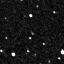

1

In [130]:
# display image
i = 1
ind = df_train.at[i,'index']
agn = df_train.at[i,'AGN']
ra = df_train.at[i,'RA']
dec = df_train.at[i,'DEC']
print(f'Source {ind} at {ra},{dec} is AGN: {agn}.')
im = Image.fromarray(train_set_x_orig[i,:,:,0])
display(im, Image.LANCZOS)


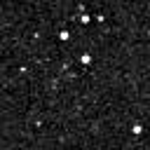
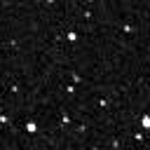
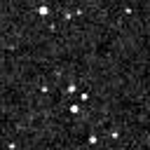
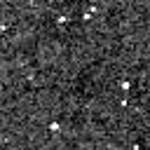
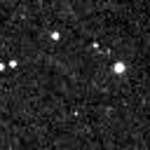
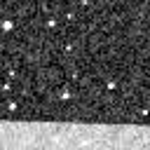
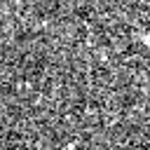
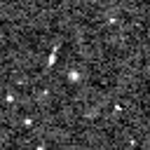
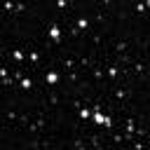
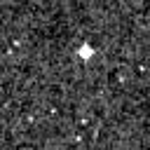
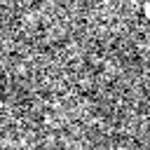
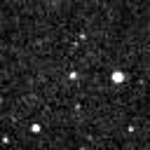
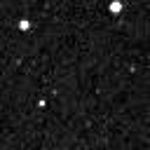
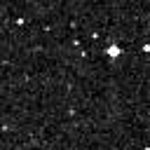
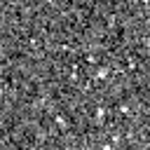
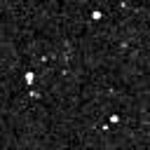
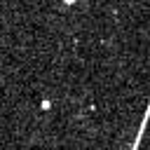
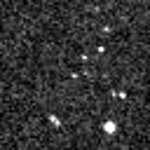
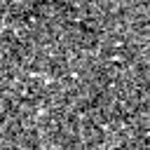
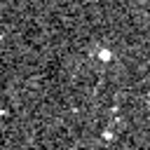
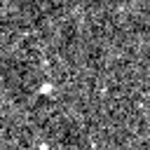
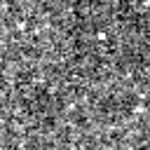
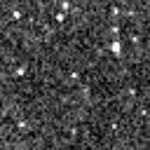
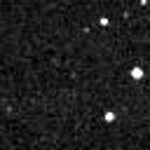
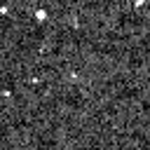
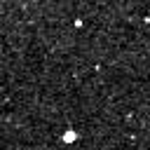
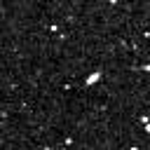
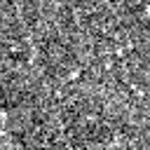
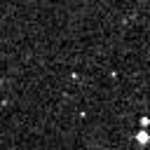
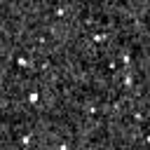
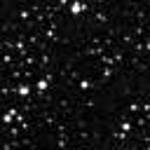
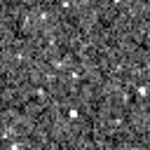
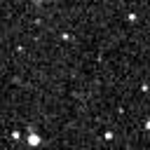
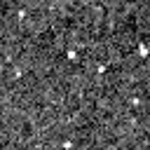
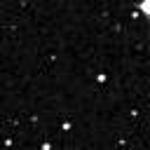
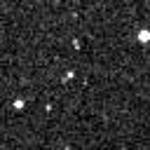
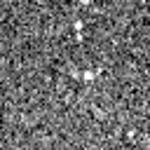
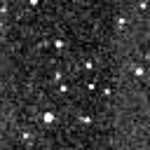
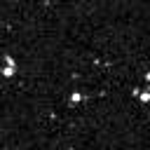
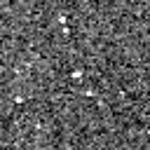
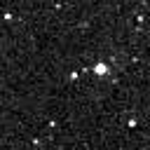
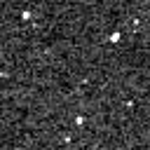
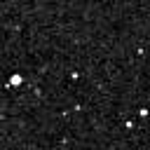
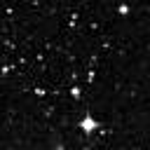
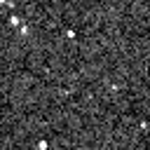
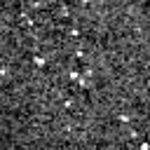
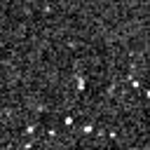
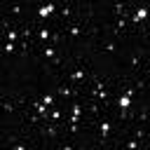
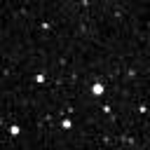
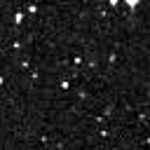
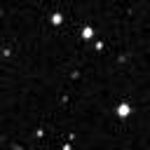
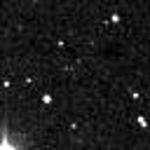
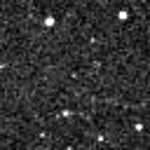
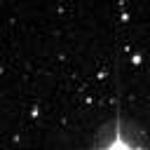
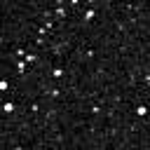
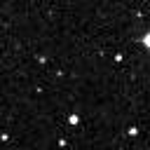
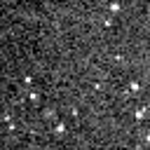
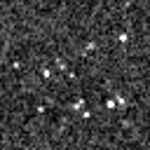
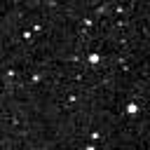
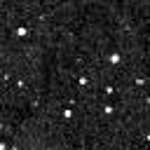
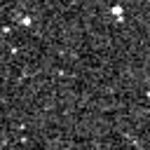
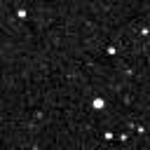
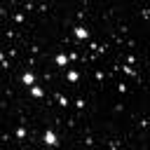
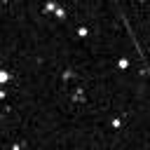
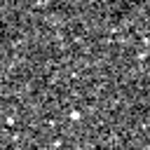
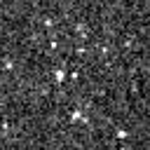
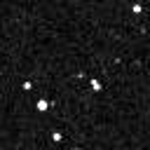
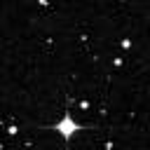
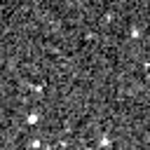
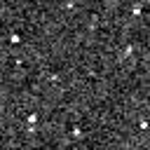
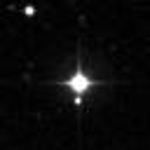
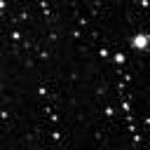
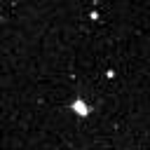
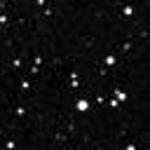
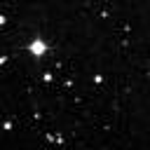
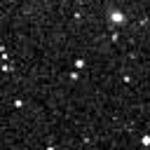
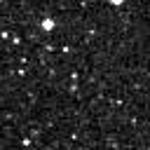
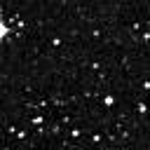
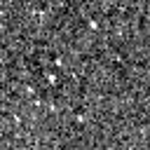
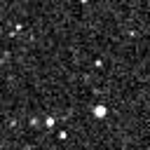
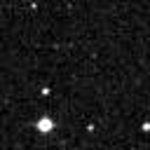
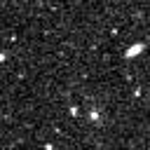
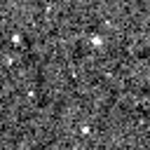
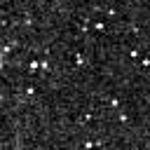
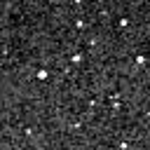
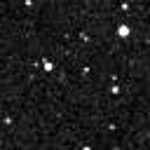
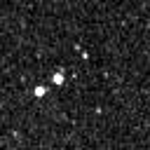
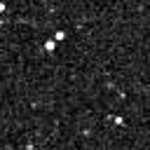
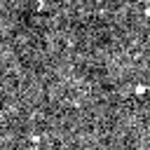
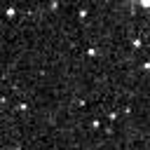
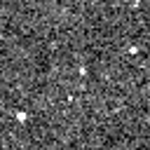
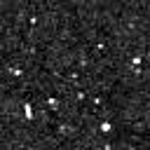
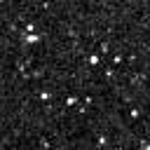
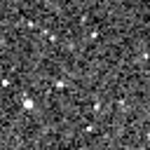
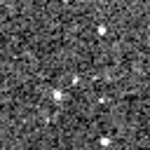
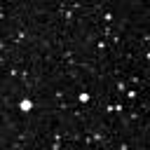
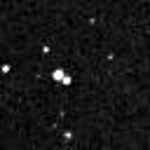
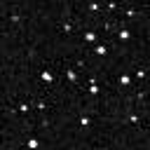
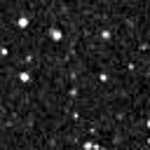
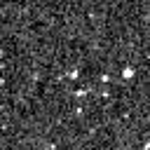
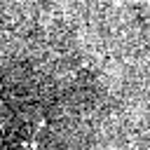
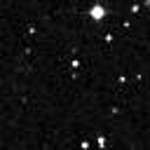
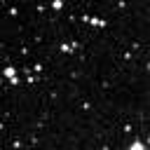
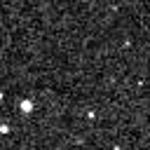
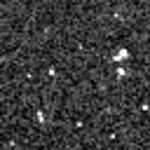
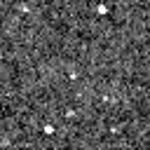
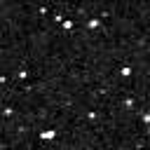
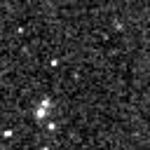
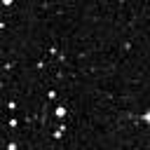
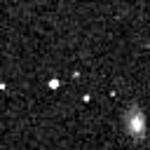
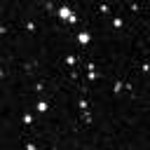
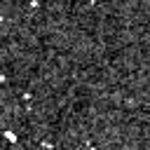
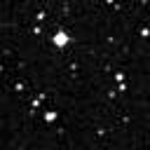
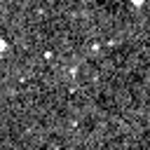
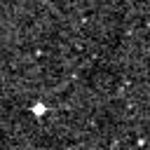
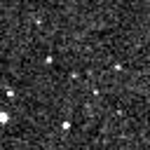
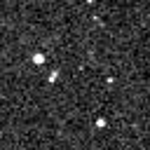
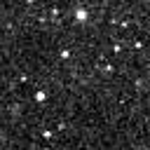
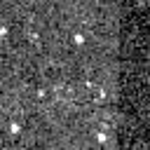
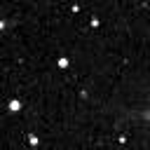


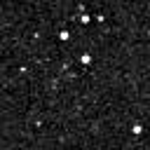
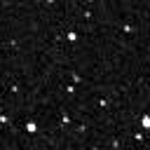
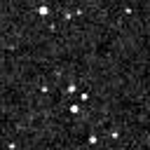
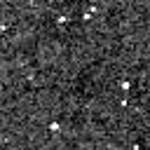
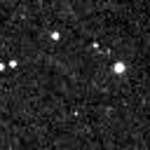
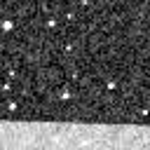
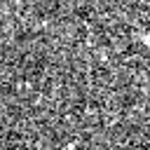
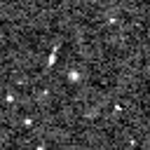
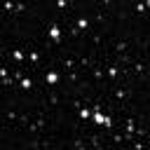
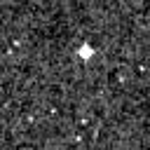
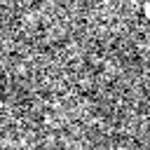
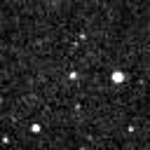
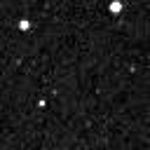
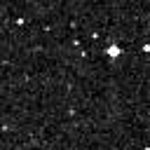
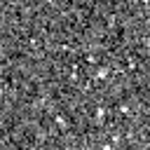
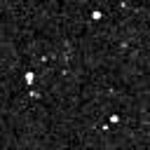
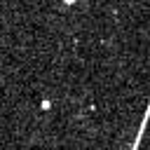
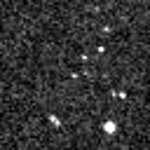
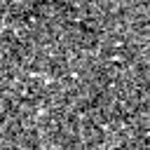
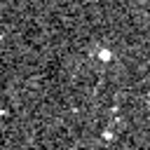
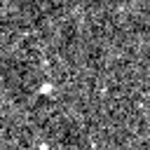
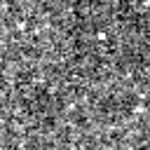
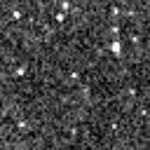
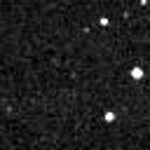
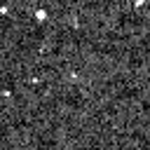
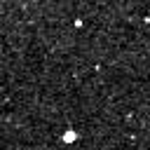
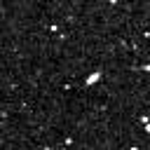
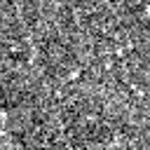
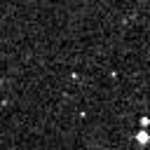
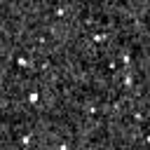
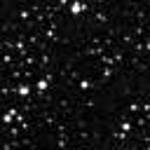
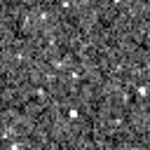
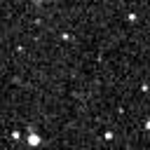
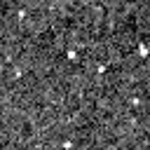
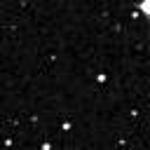
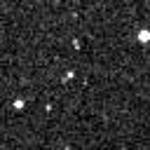
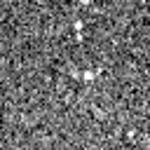
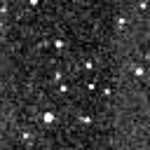
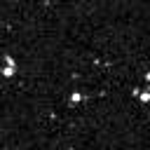
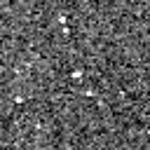
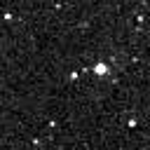
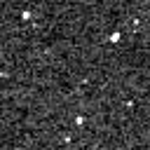
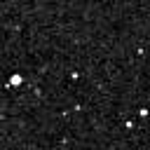
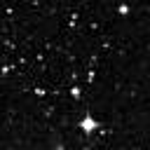
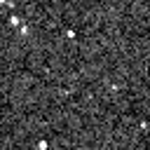
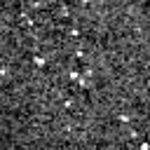
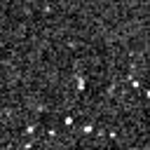
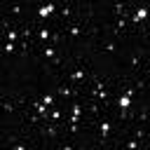
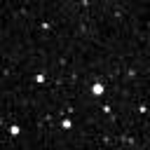
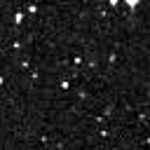
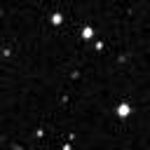
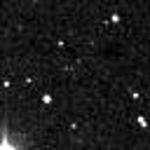
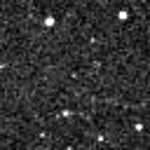
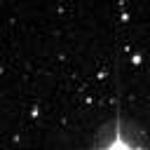
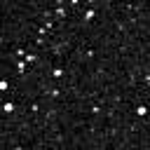
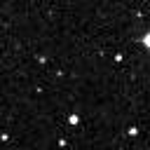
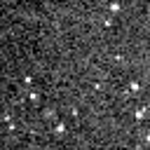
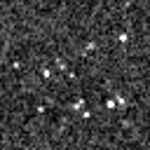
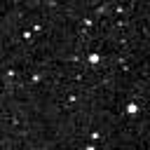
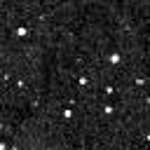
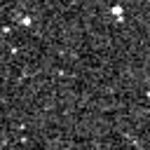
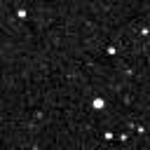
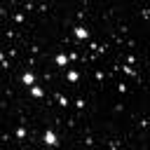
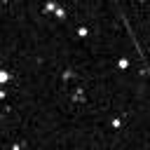
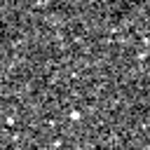
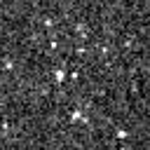
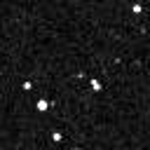
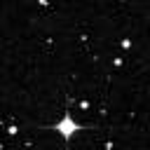
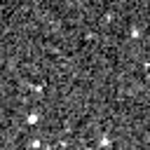
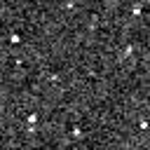
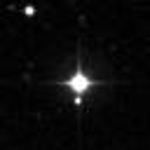
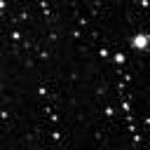
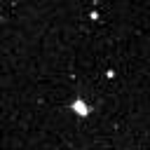
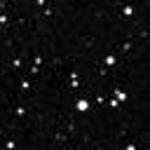
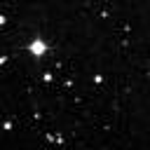
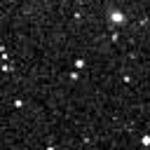
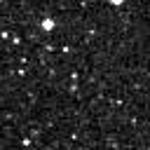
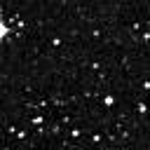
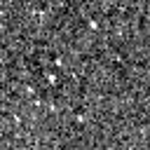
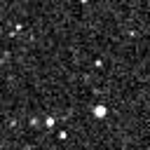
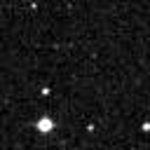
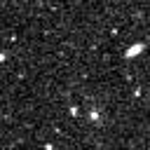
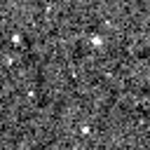
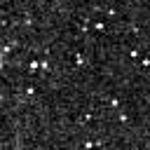
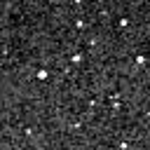
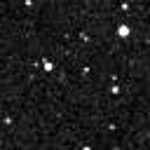
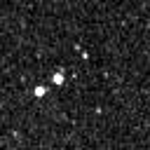
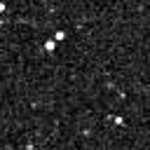
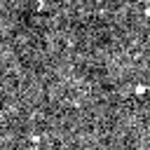
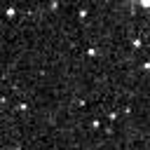
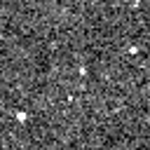
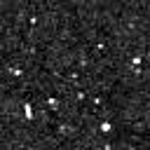
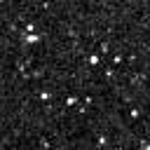
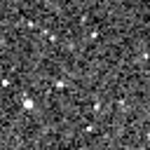
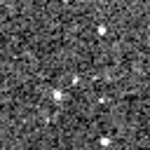
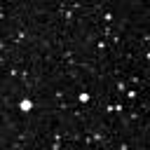
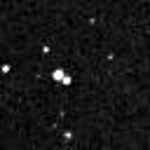
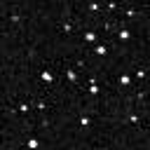
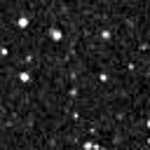
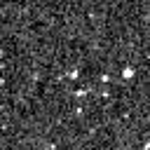
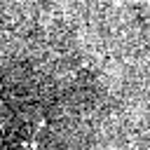
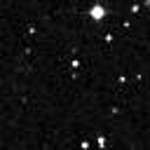
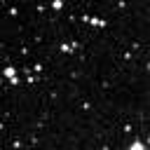
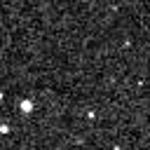
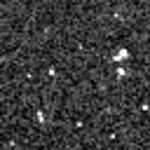
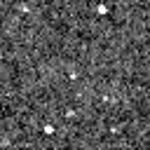
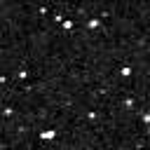
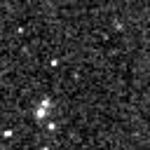
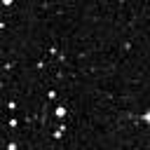
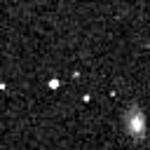
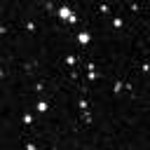
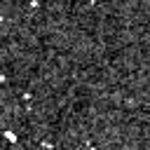
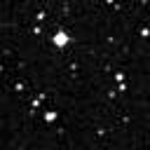
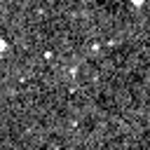
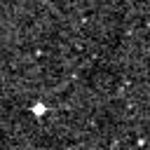
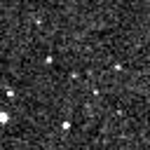
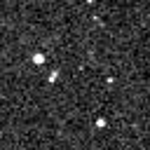
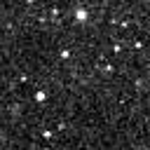
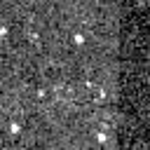
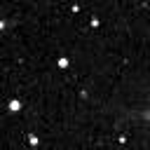

In [129]:
import ipyplot

ipyplot.plot_images(train_set_x_orig[:,:,:,0], labels=train_set_y_orig, max_images=120, img_width=150)

### Data Issues
Is the data that you collected representative of the problem to be solved?

# Data Preparation
Data must be prepared in a way that addresses missing or invalid values and removes duplicates, toward ensuring that everything is properly formatted.

# Data Modelling
These models are based on the analytic approach that was taken, either statistically driven or machine learning driven.

# Model Evaluation
Model evaluation can have two main phases. The first is the diagnostic measures phase, which is used to ensure the model is working as intended. The second phase is statistical significance testing.

# Model Deployment
Once the model is evaluated and the data scientist is confident it will work, it is deployed and put to the ultimate test.

# Feedback
Once in play, feedback from the users will help to refine the model and assess it for performance and impact.